In [1]:
import sys
sys.path.append("../")
sys.path.append("../RecipeAnalysis/")

import settings

import pycrfsuite

import json

import db.db_settings as db_settings
from db.database_connection import DatabaseConnection

from Tagging.conllu_generator import ConlluGenerator
from Tagging.crf_data_generator import *

from RecipeAnalysis.Recipe import Ingredient

from difflib import SequenceMatcher

import numpy as np

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

from graphviz import Digraph

import itertools

import random

import plotly.io as pio
pio.renderers.default = "jupyterlab"

from IPython.display import Markdown, HTML, display

from copy import deepcopy

In [2]:
import pickle
m_act = pickle.load(open("m_act.pickle", "rb"))
m_mix = pickle.load(open("m_mix.pickle", "rb"))
m_base_act = pickle.load(open("m_base_act.pickle", "rb"))
m_base_mix = pickle.load(open("m_base_mix.pickle", "rb"))

c_act = m_act.get_csr()
c_mix = m_mix.get_csr()
c_base_act = m_base_act.get_csr()
c_base_mix = m_base_mix.get_csr()


In [3]:
actions = m_act.get_labels()[0]

In [4]:
base_ingredients = m_base_mix.get_labels()

In [5]:
def get_sym_adjacent(key, m, c):
    index = m._label_index[key]
    i1 = c[index,:].nonzero()[1]
    i2 = c[:,index].nonzero()[0]
    
    i = np.concatenate((i1,i2))
    
    names = np.array(m.get_labels())[i]
    
    counts = np.concatenate((c[index, i1].toarray().flatten(), c[i2, index].toarray().flatten()))
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [6]:
def get_forward_adjacent(key, m, c):
    index = m._x_label_index[key]
    i = c[index,:].nonzero()[1]
    
    names = np.array(m._y_labels)[i]
    
    counts = c[index, i].toarray().flatten()
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [7]:
def get_backward_adjacent(key, m, c):
    index = m._y_label_index[key]
    i = c[:,index].nonzero()[0]
    
    names = np.array(m._x_labels)[i]
    
    counts = c[i, index].toarray().flatten()
    
    s = np.argsort(-counts)
    
    return names[s], counts[s]

In [8]:
def sym_sum(key, m, c):
    return np.sum(get_sym_adjacent(key,m,c)[1])

def fw_sum(key, m, c):
    return np.sum(get_forward_adjacent(key,m,c)[1])

def bw_sum(key, m, c):
    return np.sum(get_backward_adjacent(key,m,c)[1])

In [9]:
def sym_score(key_a, key_b, m, c):

    ia = m._label_index[key_a]
    ib = m._label_index[key_b]
    
    v = c[ia,ib] + c[ib,ia]
    
    if v == 0:
        return 0
    
    return max((v/sym_sum(key_a, m, c)), (v/sym_sum(key_b, m, c)))

def asym_score(key_a, key_b, m, c):
    ia = m._x_label_index[key_a]
    ib = m._y_label_index[key_b]
    
    v = c[ia,ib]
    
    if v == 0:
        return 0
    
    return max(v/fw_sum(key_a, m, c), v/bw_sum(key_b, m, c))

In [10]:
class RecipeTreeNode(object):
    
    id = 0
    
    def __init__(self, name, constant=False, single_child=False):
        self._constant = constant
        self._name = name
        self._parent = None
        
        self._id = str(RecipeTreeNode.id)
        RecipeTreeNode.id += 1
        
        self._single_child = single_child
        
        if self._single_child:
            self._child = None
            
            def child():
                return self._child
            
            def remove_child(c):
                assert c == self._child
                self._child._parent = None
                self._child = None
            
            def childs():
                c = self.child()
                if c is None:
                    return set()
                return set([c])
            
            def add_child(n):
                self._child = n
                n._parent = self
            
            self.child = child
            self.childs = childs
            self.add_child = add_child
            self.remove_child = remove_child
        else:
            self._childs = set()
            
            def childs():
                return self._childs
            
            def add_child(n):
                self._childs.add(n)
                n._parent = self
            
            def remove_child(c):
                assert c in self._childs
                c._parent = None
                self._childs.remove(c)
            
            self.childs = childs
            self.add_child = add_child
            self.remove_child = remove_child
    
    def parent(self):
        return self._parent
    
    def name(self):
        return self._name
    
    def traverse(self):
        l = []
        
        for c in self.childs():
            l += c.traverse()
        
        return [self] + l
    
    def traverse_ingredients(self):
        ingredient_set = []
        for c in self.childs():
            ingredient_set += c.traverse_ingredients()
        
        return ingredient_set
    
    def remove(self):
        p = self.parent()
        childs = self.childs().copy()
        
        assert p is None or not (len(childs) > 1 and p._single_child)
        
        for c in childs:
            self.remove_child(c)
        
        if p is not None:
            p.remove_child(self)
            
            if self._single_child and self._child is not None and p._name == self._child._name:
                # two adjacent nodes with same name would remain after deletion.
                # merge them! (by adding the child's childs to our parent instead of our childs)
                childs = self._child.childs()
                self._child.remove()
                
            
            for c in childs:
                p.add_child(c)
    
    def insert_before(self, n):
        p = self._parent
        if p is not None:
            p.remove_child(self)
            p.add_child(n)
        n.add_child(self)
        
    def mutate(self):
        n_node = self.n_node_mutate_options()
        n_edge = self.n_edge_mutate_options()
        
        choice = random.choice(range(n_node + n_edge))
        if choice < n_node:
            self.mutate_node()
        else:
            self.mutate_edges()
    
    def mutate_edges(self):
        ings = self.traverse_ingredients()
        ing = random.choice(ings)
        
        a, w = get_backward_adjacent(ing._base_ingredient, m_base_act, c_base_act)
 
        action = random.choices(a, w)[0]
        self.insert_before(ActionNode(action))
    
    def mutate_node(self):
        raise NotImplementedError
    
    def n_node_mutate_options(self):
        
        return 0 if self._constant else 1
    
    def n_edge_mutate_options(self):
        n = 1 if self._parent is not None else 0
        return n
    
    def n_mutate_options(self):
        return self.n_edge_mutate_options() + self.n_node_mutate_options()
        
    def dot_node(self, dot):
        raise NotImplementedError()
    
    def dot(self, d=None):
        if d is None:
            d = Digraph()
            self.dot_node(d)
        
        else:
            self.dot_node(d)
            if self._parent is not None:
                d.edge(self._parent._id, self._id)
        
        
        for c in self.childs():
            c.dot(d)
        
        return d
    
    def serialize(self):
        r = {}
        r['type'] = str(self.__class__.__name__)
        r['id'] = self._id
        r['parent'] = self._parent._id if self._parent is not None else None
        r['name'] = self._name
        r['childs'] = [c._id for c in self.childs()]
        r['constant'] = self._constant
        r['single_child'] = self._single_child
        
        return r
    
    def node_score(self):
        raise NotImplementedError()
        
    

In [11]:
class MixNode(RecipeTreeNode):
    def __init__(self, constant=False):
        super().__init__("mix", constant, single_child=False)
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"{self._name} ({self.node_score()})", shape="diamond")
    
    def split(self, set_above, set_below, node_between):
        assert len(set_above.difference(self.childs())) == 0
        assert len(set_below.difference(self.childs())) == 0
        
        n_above = MixNode()
        n_below = MixNode()
        
        p = self.parent()
        
        for c in self.childs().copy():
            self.remove_child(c)
        self.remove()
        
        for c in set_below:
            n_below.add_child(c)
        
        for c in set_above:
            n_above.add_child(c)
        
        n_above.add_child(node_between)
        node_between.add_child(n_below)
        
        if p is not None:
            p.add_child(n_above)
        
        # test whether the mix nodes are useless
        if len(n_above.childs()) == 1:
            n_above.remove()
        
        if len(n_below.childs()) == 1:
            n_below.remove()
    
    def n_node_mutate_options(self):
        return 0 if self._constant or len(self.childs()) <= 2 else len(self.childs())
    
    def mutate_node(self):
        
        childs = self.childs()
        
        if len(childs) <= 2:
            print("Warning: cannot modify mix node")
            return
        
        childs = random.sample(childs, len(childs))
        
        n = random.choice(range(1, len(childs)-1))
        
        between_node = ActionNode(random.choice(actions))
        
        self.split(set(childs[:n]), set(childs[n:]), between_node)
        
    
    def node_score(self):
        child_ingredients = [c.traverse_ingredients() for c in self.childs()]
        products = [itertools.product(child_ingredients[i-1],child_ingredients[i]) for i in range(len(child_ingredients))]
        pairwise_tuples = []
        for p in products:
            pairwise_tuples += [x for x in p]
        
        s_base = 0
        s = 0
        
        for ing_a, ing_b in pairwise_tuples:
            try:
                #s_base += sym_score(ing_a._base_ingredient, ing_b._base_ingredient, m_base_mix, c_base_mix)
                s += sym_score(ing_a.to_json(), ing_b.to_json(), m_mix, c_mix)
            except:
                pass
        
        #s_base /= len(pairwise_tuples)
        s /= len(pairwise_tuples)
        
        #return 0.5 * (s_base + s)
        return s
    
        
        
        

In [12]:
class IngredientNode(RecipeTreeNode):
    def __init__(self, name, constant=False):
        super().__init__(name, constant, single_child=True)
    
    def get_actions(self):
        a_set = set()
        n = self.parent()
        while n is not None:
            if type(n) == ActionNode:
                a_set.add(n.name())
        return a_set
    
    def mutate_node(self):
        self._name = random.choice(base_ingredients)
    
    def traverse_ingredients(self):
        return [Ingredient(self._name)]
    
    def node_score(self):
        return 0
        
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"{self._name} ({self.node_score()})", shape="box")

In [13]:
class ActionNode(RecipeTreeNode):
    def __init__(self, name, constant=False):
        super().__init__(name, constant, single_child=True)
    
    def n_node_mutate_options(self):
        # beacause we can change or remove ourselve!
        return 0 if self._constant else 2 
    def mutate_node(self):
        if random.choice(range(2)) == 0:
            # change action
            self._name = random.choice(actions)
        else:
            # delete
            self.remove()
    
    def traverse_ingredients(self):
        ingredient_set = super().traverse_ingredients()
        for ing in ingredient_set:
            ing.apply_action(self._name)
        
        return ingredient_set
    
    def node_score(self):
        ings = self.child().traverse_ingredients()
        
        s = 0
        
        for ing in ings:
            try:
                score = asym_score(self._name, ing.to_json(), m_act, c_act)
                #base_score = asym_score(self._name, ing._base_ingredient, m_base_act, c_base_act)
                s +=  score
            except KeyError as e:
                pass
                
        
        return s / len(ings)
    
    def dot_node(self, dot):
        dot.node(self._id, label=f"{self._name} ({self.node_score()})", shape="ellipse")

In [14]:
class Tree(object):
    
    @staticmethod
    def from_ingredients(ingredients: list):
        root = MixNode()
        
        for ing in ingredients:
            root.add_child(IngredientNode(ing, constant=True))
        
        return Tree(root)
    
    @staticmethod
    def from_serialization(s):
        def empty_node(raw_n):
            if raw_n['type'] == "MixNode":
                node = MixNode(raw_n['constant'])
            elif raw_n['type'] == "IngredientNode":
                node = IngredientNode(raw_n['name'], raw_n['constant'])
            elif raw_n['type'] == "ActionNode":
                node = ActionNode(raw_n['name'], raw_n['constant'])
            else:
                print("unknown node detected")
                return
            
            return node
        
        nodes = {}
        for n in s:
            nodes[n['id']] = empty_node(n)
        
        for n in s:
            childs = n['childs']
            id = n['id']
            for c in childs:
                nodes[id].add_child(nodes[c])
        
        return Tree(nodes[s[0]['id']])
            
    
    def __init__(self, root):
        # create a dummy entry node
        self._root = RecipeTreeNode("root", single_child=True)
        self._root.add_child(root)
    
    def root(self):
        return self._root.child()
    
    def mutate(self):
        nodes = self.root().traverse()
        weights = [n.n_mutate_options() for n in nodes]
        
        n = random.choices(nodes, weights)[0]
        
        n.mutate()
    
    def dot(self):
        return self.root().dot()
    
    def serialize(self):
        return [n.serialize() for n in self.root().traverse()]
    
    def structure_score(self):
        n_duplicates = 0
        
        
        
    
    def score(self):
        
        scores = []
        
        nodes = self.root().traverse()
        n_nodes = 0
        s = 0
        for n in nodes:
            if type(n) != IngredientNode:
                scores.append(n.node_score())
                n_nodes += 1
                
        n_duplicates = 0
        seen_actions = set()
        
        for n in nodes:
            if type(n) == ActionNode:
                if n.name() in seen_actions:
                    n_duplicates += 1
                else:
                    seen_actions.add(n.name())
        
        
        return (sum(scores)/n_nodes)  + 1 / (n_duplicates + 1)
    
    def copy(self):
        return Tree.from_serialization(self.serialize())


In [15]:
class Population(object):
    def __init__(self, start_ingredients, n_population = 10):
        self.population = [Tree.from_ingredients(start_ingredients) for i in range(n_population)]
        self._n = n_population
    
    def mutate(self):
        for tree in self.population.copy():
            t_clone = tree.copy()
            t_clone.mutate()
            self.population.append(t_clone)
    
    def pairwise_competition(self):
        new_population = []
        random.shuffle(self.population)
        
        for i in range(self._n):
            t_a = self.population[2*i]
            t_b = self.population[2*i+1]
            
            if t_a.score() > t_b.score():
                new_population.append(t_a)
            else:
                new_population.append(t_b)
        
        self.population = new_population
    
    def run(self, n=50):
        for i in range(n):
            print(i)
            self.mutate()
            self.pairwise_competition()
    
    def plot_population(self):
        for t in self.population:
            display(t.root().dot())

In [16]:
p = Population(["bacon", "mushroom", "noodle", "water", "egg"])

In [17]:
p.run(20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


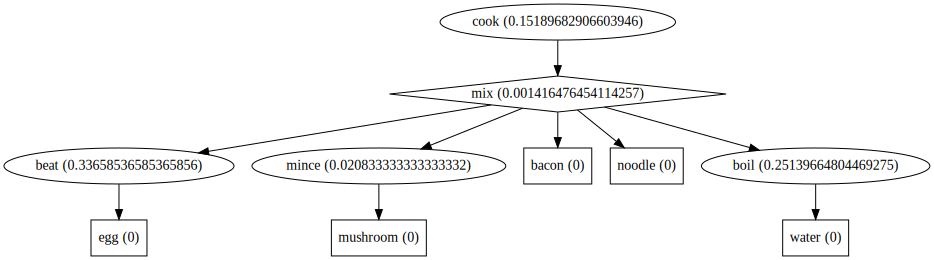

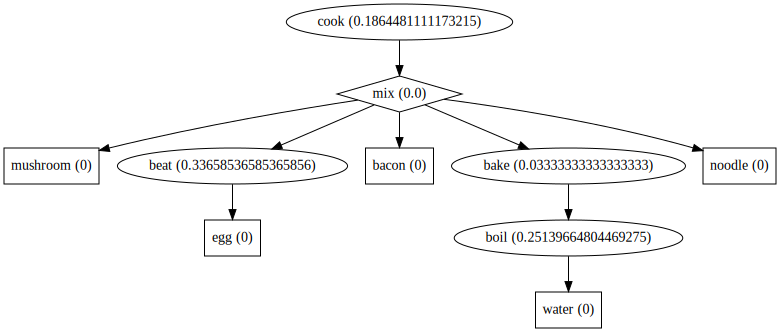

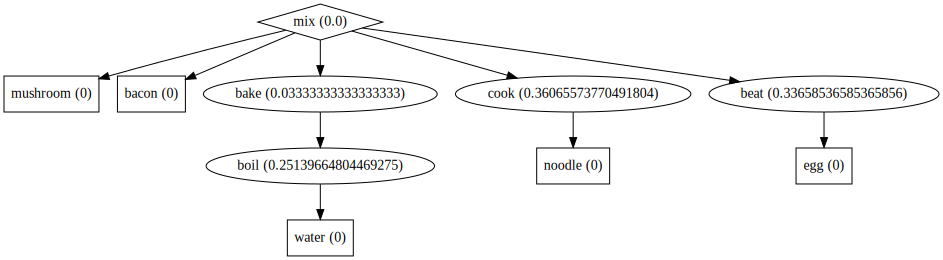

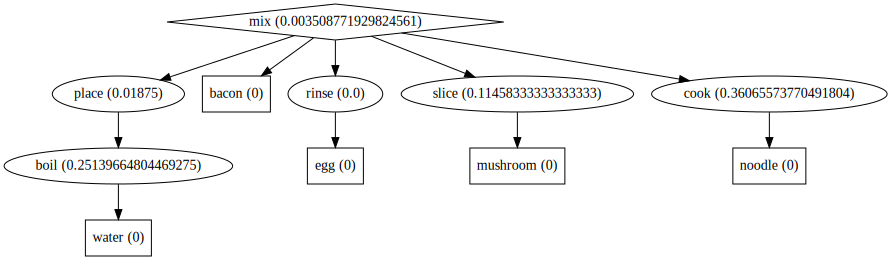

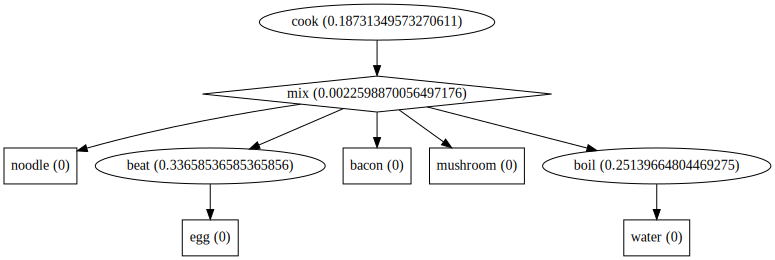

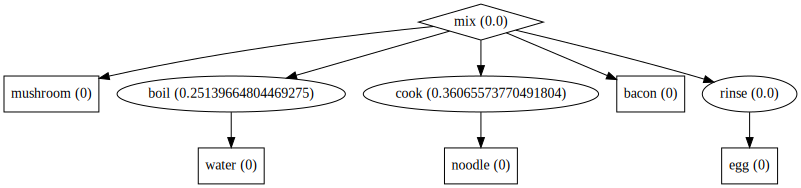

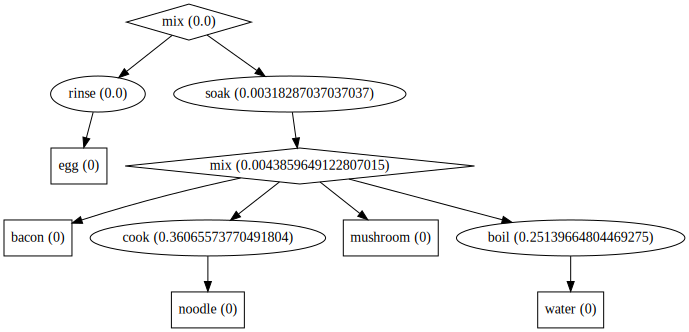

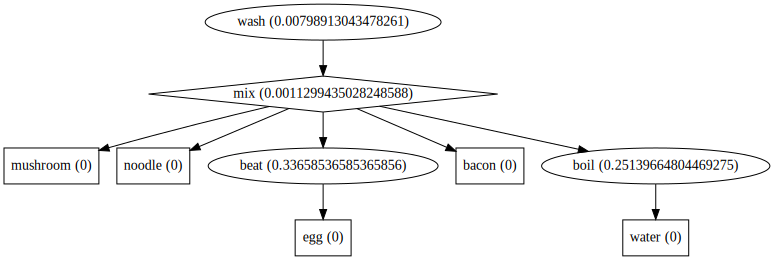

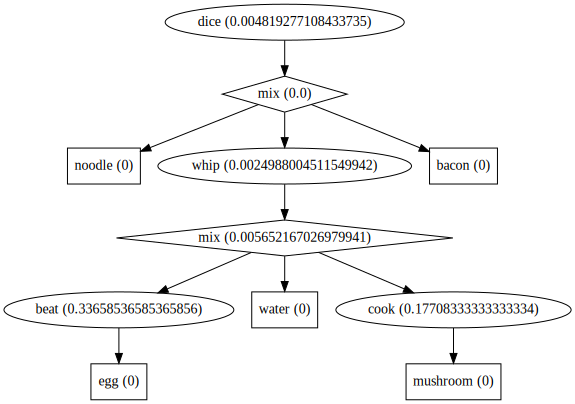

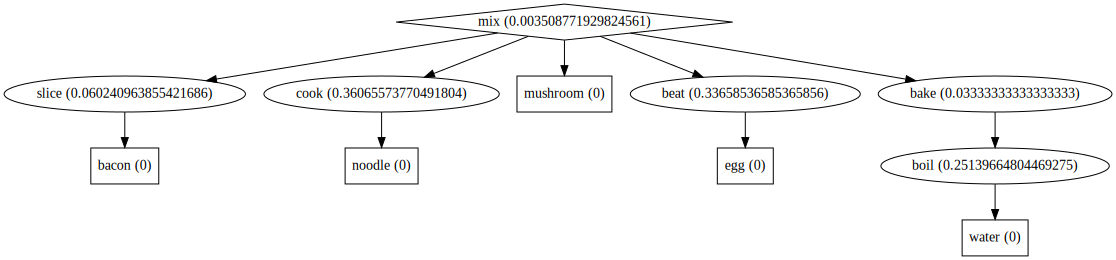

In [18]:
p.plot_population()

In [48]:
t2 = Tree.from_serialization(t.serialize())

In [49]:
t.mutate()

In [54]:
t.score()

0.00499001996007984

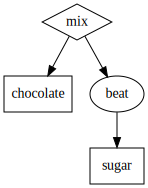

In [51]:
t.root().dot()

In [32]:
list(t.root().childs())[0]._name

'pepper'

In [42]:
n = IngredientNode("test")

In [43]:
n.traverse() == IngredientNode

True